# Project: Communicate Data Findings
By: odubajo abdul qoyyum
## Table of Contents

## Investigation Overview

In this investigation I wanted to figure out two things:
<ul>
    <li>The factors which can be used to predict default on credit.</li>
    <li>What factors influence Prosper rating.</li>
</ul>

## Dataset Overview

This dataset contains information on peer to peer loans facilitated by credit company Prosper. There are 113,937 loans with 81 variables. For the purpose of this investigation I've taken the following variables: Term, LoanStatus, BorrowerRate, EstimatedReturn, ProsperRating (Alpha), ListingCategory (numeric), EmploymentStatus, IsBorrowerHomeowner, StatedMonthlyIncome, TotalProsperLoans, LoanOriginalAmount, LoanOriginationDate and Investors.

<a id='sources'></a>
## Data Source


>1. **Name:** loan data (prosperLoanData.csv)</li>
><ul>   
>    <li><b>Source:</b>Udacity</li>    
>    <li><b>Method of gathering:</b> Manual download</li>
></ul>


### Import all packages and set plots to be embedded inline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

%matplotlib inline

In [2]:
#reading in the initial cleaned data
loan_sub =pd.read_csv("cleaned_loan_data.csv")

## Wrangling
There were three major issues with data:
<ol>
    <li>Prosper started to use Prosper rating from 2009. Pre 2009 Prosper used Credit Grade. I had to remove pre 2009 data points entirely</li>
    <li>Most of the loans in dataset are actually current loans and can not be used to determine how default on credit can be predicted. Defaulted credits were split in two categries chargedoff and defaulted (see sub-slide). To solve this I've removed all the current loans and merged chargedoff and defaulted credits together.</li>
    <li>Stated monthly income had an unusually high number of outliers and very large range of values from 0 to 1 750 000. To solve this I've dropped all the data above two standard deviations from the mean.</li>
</ol>

In [3]:
#setting the default color palette

#base_color = sns.color_palette()[5]

base_color= sns.color_palette("vlag")[1]

In [4]:
# dropping the Nulls from 'ProsperRating (Alpha)', 'EstimatedReturn'
loan_sub = loan_sub.dropna(subset=['ProsperRating (Alpha)','EstimatedReturn']).reset_index()


#filling the NAN values with zero
loan_sub['TotalProsperLoans']=loan_sub['TotalProsperLoans'].fillna(0)

## Distribution of Loan Status

> Loan status is the outcome of the loan taken. It can be completed, defaulted, chargedoff, due or currently ongoing

> Most of the loans are current loans while a lot are also completed loans

> Minority of the loans are past due also

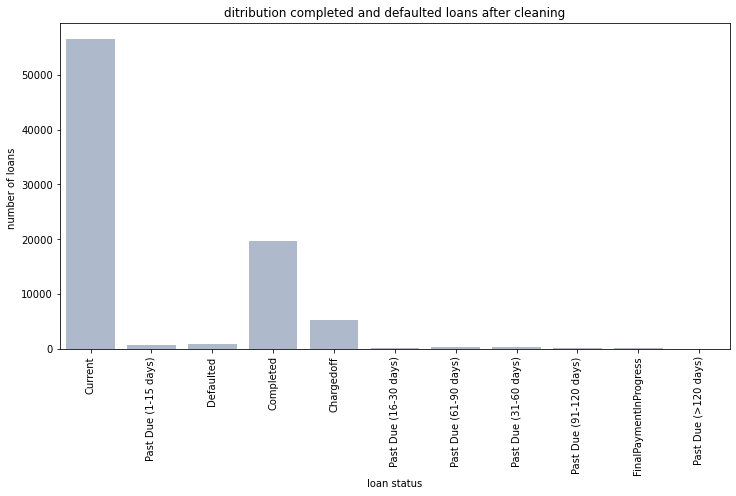

In [5]:
plt.figure(figsize=[12, 6])
sns.countplot(data = loan_sub, x = 'LoanStatus', color = base_color);

# Labeling the axes
plt.xlabel('loan status')
plt.ylabel('number of loans ')
plt.xticks(rotation=90)
plt.title('ditribution completed and defaulted loans after cleaning')

# Dsiplay the plot
plt.show()

> - After wrangling there are 25921 loans in data set: 19579 completed loans and 6342 defaulted.

In [6]:
### replacing charrged off loans with defaulted since both of them technically werent paid back

loan_sub['LoanStatus'].replace(to_replace =["Chargedoff",],value ="Defaulted",inplace=True)

#filering to get only completed and defaulted loans

values=['Completed', 'Defaulted']

loan_sub=loan_sub[loan_sub['LoanStatus'].isin(values)]


In [7]:
#converting to a categorical data

values_list=['Completed', 'Defaulted']

status= pd.api.types.CategoricalDtype(ordered=True, categories=values_list)

loan_sub['LoanStatus']=loan_sub['LoanStatus'].astype(status)

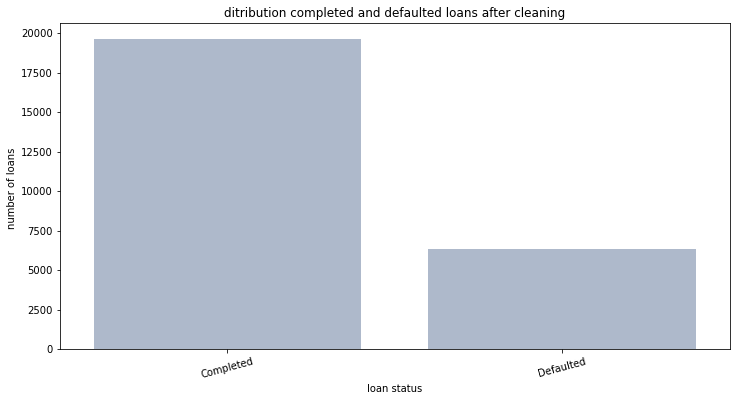

In [8]:
plt.figure(figsize=[12, 6])
sns.countplot(data =loan_sub, x = 'LoanStatus', color = base_color);

# Labeling the axes
plt.xlabel('loan status')
plt.ylabel('number of loans ')
plt.xticks(rotation=15)
plt.title('ditribution completed and defaulted loans after cleaning')

# Dsiplay the plot
plt.show()

## lets look at the monthly income distribution

> - After wrangling Distribution of Monthly income looks right skewed and a mean of 5261 USD and maximum value of 23225.00 USD.

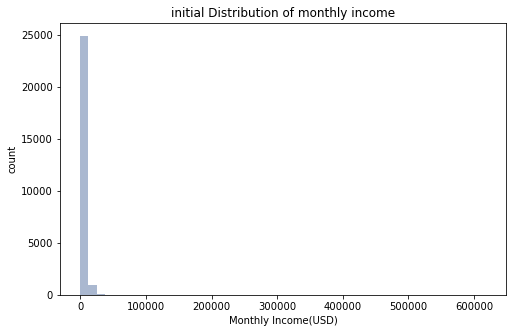

In [9]:
plt.figure(figsize=[8, 5])
plt.hist(data=loan_sub, x='StatedMonthlyIncome', bins=50, color=base_color);
plt.title('initial Distribution of monthly income')
plt.xlabel('Monthly Income(USD)')
plt.ylabel('count')
plt.show()

In [10]:
loan_sub['StatedMonthlyIncome'].describe()

count     26005.000000
mean       5489.858636
std        6824.132771
min           0.000000
25%        3166.666667
50%        4583.333333
75%        6666.666667
max      618547.833333
Name: StatedMonthlyIncome, dtype: float64

In [11]:
mean=loan_sub['StatedMonthlyIncome'].std()
std=loan_sub['StatedMonthlyIncome'].mean()

#generating the treshold
treshold=mean+std*3

#getting the data below the treshold

loan_sub=loan_sub[loan_sub['StatedMonthlyIncome'] <=treshold]

In [12]:
loan_sub['StatedMonthlyIncome'].describe()

count    25856.000000
mean      5261.815024
std       3181.168248
min          0.000000
25%       3162.291667
50%       4583.333333
75%       6666.666667
max      23225.000000
Name: StatedMonthlyIncome, dtype: float64

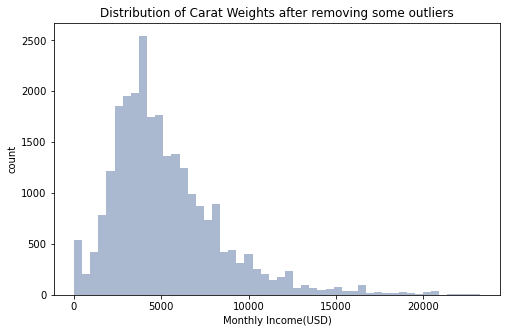

In [13]:
plt.figure(figsize=[8, 5])
plt.hist(data=loan_sub, x='StatedMonthlyIncome', bins=50, color=base_color);
plt.title('Distribution of Carat Weights after removing some outliers')
plt.ylabel('count')
plt.xlabel('Monthly Income(USD)')
plt.show()

### Borrower rate is the the borrower's interest rate for each loan

>  borrower rate of approximately 0.32 is the most common

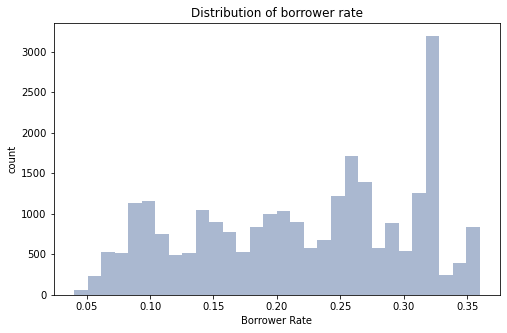

In [14]:
plt.figure(figsize=[8, 5])
plt.hist(data=loan_sub, x='BorrowerRate', bins=30, color=base_color);
plt.title('Distribution of borrower rate')
plt.xlabel('Borrower Rate')
plt.ylabel('count')
plt.show()

> ProsperRating is an ordinal categorical variable with the following values from higher to lower ('AA', 'A', 'B', 'C', 'D', 'E', 'HR')

> distribution in data set centered at 'D' and the least frequent rating is  'AA' 

> the highly rated loans are taken often

> the original loan amount decreases as the  prosper rating decreases 

>  there are a lot of outliers but loans with high prosper rating have less borrower rate

In [15]:
#converting this data to a categorical data

rating_list = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = rating_list)
loan_sub['ProsperRating (Alpha)'] = loan_sub['ProsperRating (Alpha)'].astype(ordered_var)

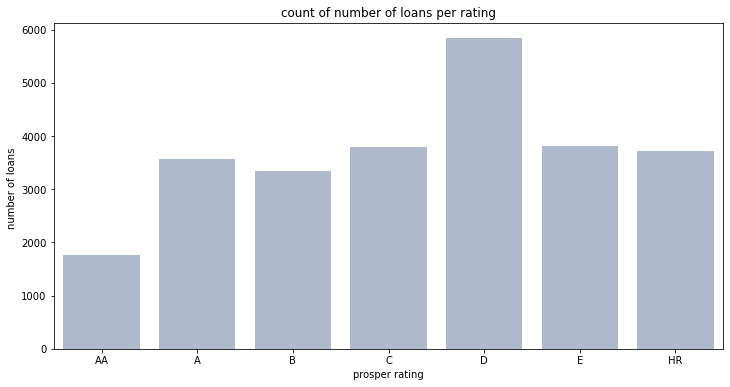

In [16]:
plt.figure(figsize=[12, 6])
sns.countplot(data =loan_sub, x = 'ProsperRating (Alpha)', color = base_color);

# Labeling the axes
plt.xlabel('prosper rating')
plt.ylabel('number of loans ')
plt.title('count of number of loans per rating')

# Dsiplay the plot
plt.show()

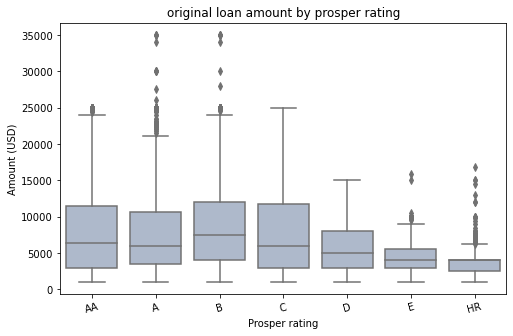

In [17]:
plt.figure(figsize = [8, 5])

sns.boxplot(data=loan_sub, x='ProsperRating (Alpha)', y='LoanOriginalAmount', color=base_color)
plt.xticks(rotation=15);
plt.title("original loan amount by prosper rating");
plt.xlabel('Prosper rating')
plt.ylabel('Amount (USD)');

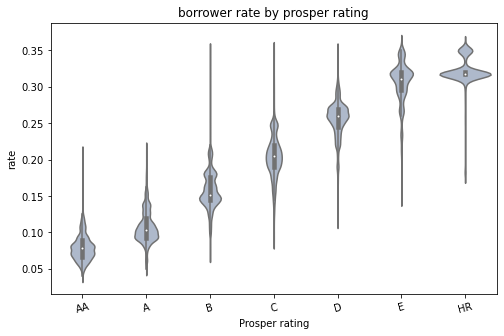

In [18]:
plt.figure(figsize = [8, 5])

sns.violinplot(data=loan_sub, x='ProsperRating (Alpha)', y='BorrowerRate', color=base_color)
plt.xticks(rotation=15);
plt.title("borrower rate by prosper rating");
plt.xlabel('Prosper rating')
plt.ylabel('rate');

> - as the loan rating decreases the number of defaulted loans increases

> - That is actually interesting: The most common loan rating is `D`  and it is also the frequent rating among defaulted loans

> - majority of the loans are taken for 36 months across all ratings. the `HR` rating loans are only taken for 36 months

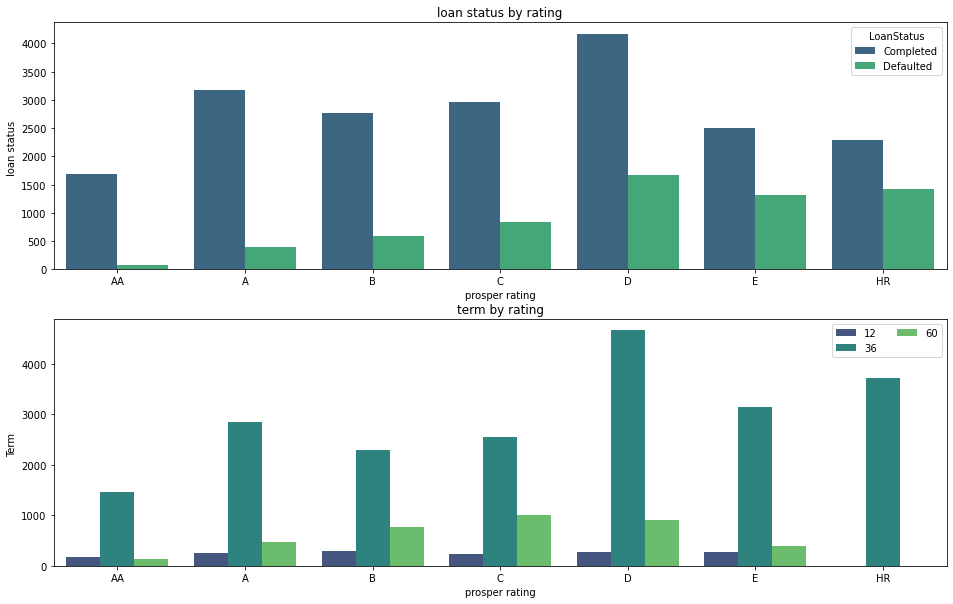

In [19]:
plt.figure(figsize = [16, 10])

# subplot 1:
plt.subplot(2, 1, 1)
sns.countplot(data = loan_sub, x =  'ProsperRating (Alpha)', hue = 'LoanStatus', palette = "viridis")
# Labeling the axes
plt.xlabel('prosper rating')
plt.ylabel('loan status ')
plt.title('loan status by rating')


# subplot 2: 
ax = plt.subplot(2, 1, 2)
sns.countplot(data = loan_sub, x = 'ProsperRating (Alpha)', hue = 'Term',  palette = "viridis")
# Labeling the axes
plt.xlabel('prosper rating')
plt.ylabel('Term ')
plt.title('term by rating')

ax.legend(loc = 1, ncol = 2) 

plt.show()

> Borrowers with higher ratings on average have more investors

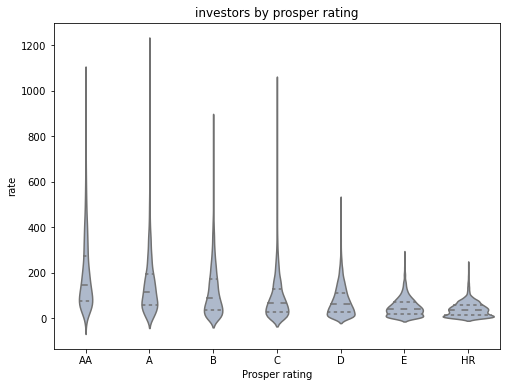

In [20]:
plt.figure(figsize = [8, 6])

sns.violinplot(data = loan_sub, x='ProsperRating (Alpha)', y='Investors', color = base_color,inner='quartile');
plt.xlabel('Prosper rating')
plt.ylabel('rate');
plt.title("investors by prosper rating");

> - Borrower Rate for defaulted loans is considerably higher than for the completed 

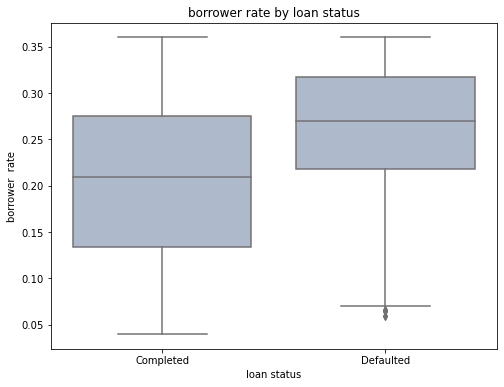

In [21]:
plt.figure(figsize = [8, 6])

sns.boxplot(data = loan_sub, x='LoanStatus', y='BorrowerRate', color = base_color);
plt.xlabel('loan status')
plt.ylabel('borrower  rate');
plt.title("borrower rate by loan status");

> the 60 months Term credit have a high rate of defaults

Text(0.5, 1.0, 'term by rating')

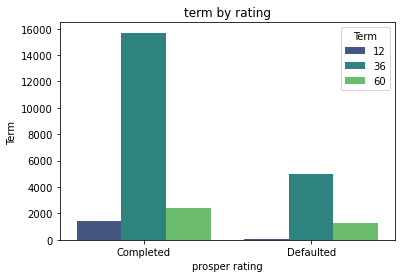

In [22]:
sns.countplot(x = 'LoanStatus', data = loan_sub, hue='Term', palette = "viridis")
# Labeling the axes
plt.xlabel('prosper rating')
plt.ylabel('Term ')
plt.title('term by rating')

> - the estimated return increases as the rating decreases 

> - the HR rating has a lot of negative estimated return

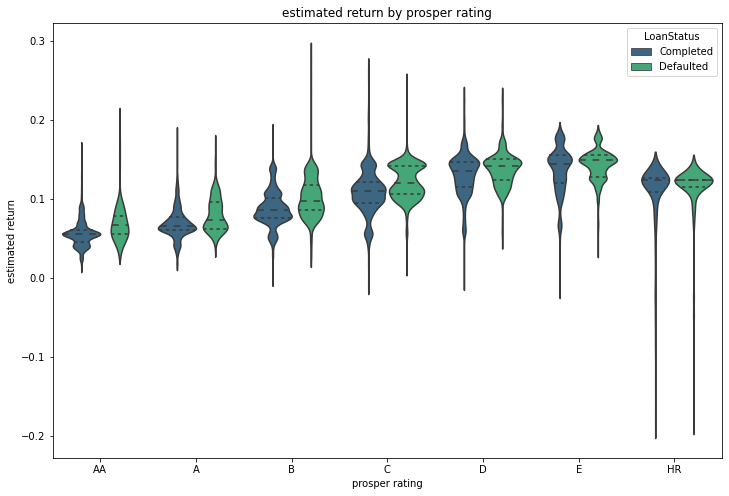

In [23]:
plt.figure(figsize = [12, 8])
sns.violinplot(data=loan_sub, x='ProsperRating (Alpha)', y='EstimatedReturn', hue='LoanStatus', palette="viridis",inner='quartile')
plt.xlabel('prosper rating')
plt.ylabel('estimated return');
plt.title("estimated return by prosper rating");

In [24]:
!jupyter nbconvert Explanatory_Visualization.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Explanatory_Visualization.ipynb to slides
[NbConvertApp] Writing 730640 bytes to Explanatory_Visualization.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\qoyyum\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\qoyyum\anaconda3\lib\site-packages\jupyter_core\application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\qoyyum\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\qoyyum\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 346, in start
    self.convert_notebooks()
  File "C:\Users\qoyyum\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 518, in convert_notebooks
    self.convert_single_notebook(notebook